
<a href="https://colab.research.google.com/github/lvjonok/mujoco-sysid/blob/master/examples/mujoco_sysid_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" width="150" align="center"/></a>
<h1><center>System Identification and Linear Parametrization in Robotic Systems</center></h1>

This notebook offers a brief introduction to system identification (Sys-ID) in robotic systems. It is inspired by recent advancements in MuJoCo utilities, specifically the [Levenberg-Marquardt nonlinear least squares method](https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/least_squares.ipynb).

We focus primarily on mechanical systems where the **model structure is known**, including the number of state variables and the configuration of the kinematic tree. Although the dynamics of these systems can be inherently complex, the general forms of the equations are known and have already been implemented in MuJoCo. In this context, the task of identification essentially involves estimating the parameters within a structured model.

### Contents of This Notebook

This notebook includes the following examples:
* [Estimation of cart-pole inertial parameters through random forcing and LQR stabilization of the identified system](#cell-bwnDFHRjc836)
* [Identification of end-effector load for the Franka Emika Panda and compensation using inverse dynamics](#cell-puimYTxi6OqK)
* [Determination of mass, center of mass, and spatial inertia for a Skydio X2 Quadrotor following trajectory via LTV LQR](#cell-cKG867aUc84I)

In addition to the examples, we provide theoretical background and introduce two utility functions that can greatly facilitate system identification and adaptive control in robotic systems:

* `mj_bodyRegressor`: Calculates the regressor matrix for a single rigid body in the MuJoCo model.
* `mj_jointRegressor`: Calculates the regressor matrix for the entire inverse dynamics in the MuJoCo model.

We hope these examples and utilities will be useful for all MuJoCo users and assist in resolving their system identification challenges.

For further questions and suggestions, please do not hesitate to create an issue or start a discussion [on GitHub](https://github.com/lvjonok/mujoco-sysid).



###### Imports and config

In [ ]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess

if subprocess.run("nvidia-smi").returncode:
    raise RuntimeError(
        "Cannot communicate with GPU. "
        "Make sure you are using a GPU Colab runtime. "
        "Go to the Runtime menu and select Choose runtime type."
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = "/usr/share/glvnd/egl_vendor.d/10_nvidia.json"
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, "w") as f:
        f.write(
            """{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
"""
        )

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print("Setting environment variable to use GPU rendering:")
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
    print("Checking that the installation succeeded:")
    import mujoco

    mujoco.MjModel.from_xml_string("<mujoco/>")
except Exception as e:
    raise e from RuntimeError(
        "Something went wrong during installation. Check the shell output above "
        "for more information.\n"
        "If using a hosted Colab runtime, make sure you enable GPU acceleration "
        'by going to the Runtime menu and selecting "Choose runtime type".'
    )

print("Installation successful.")

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print("Installing mediapy:")
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output

clear_output()

# Fix random seed
np.random.seed(0)

In [ ]:
%%capture
!pip3 install dm_control robot_descriptions matplotlib scipy


import copy
import mujoco
from dm_control import mjcf
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt

## Cart Pole Sys-ID and LQR stablization

In the following introduction example we will consider the cart pole system, with unknown pendulum length and mass, as well as cart mass. The goal is to show how one can deduce these parameters given the system trajectory and measurements.

First let us download and load the model of cart pole:



In [ ]:
!git clone https://github.com/lvjonok/mujoco-sysid.git

fatal: destination path 'mujoco-sysid' already exists and is not an empty directory.


In [ ]:
CART_POLE_MJCF = "mujoco-sysid/data/models/cart_pole/model.xml"

sim_model = mujoco.MjModel.from_xml_path(CART_POLE_MJCF)
sim_data = mujoco.MjData(sim_model)
renderer = mujoco.Renderer(sim_model, height=480, width=640)

### LQR stabilization

As a first test we will perform the LQR stabilization assuming the all parameters are known, the LQR is done by computing linearization similarlly to **LQR tutorial** <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/LQR.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="90"/></a>



In [ ]:
import scipy


def compute_gains(model, data, configuration, Q, R):
    # 1. Set configuration and find control that stabilizes it (ctrl0)
    newdata = mujoco.MjData(model)
    newdata = copy.copy(data)

    mujoco.mj_resetData(model, newdata)
    newdata.qpos = configuration
    # compute the control
    mujoco.mj_forward(model, newdata)
    newdata.qacc = 0
    mujoco.mj_inverse(model, newdata)

    # define control and configuration to linearize around
    print(newdata.qfrc_actuator)
    ctrl0 = newdata.qfrc_inverse.copy() @ np.linalg.pinv(newdata.actuator_moment)
    qpos0 = newdata.qpos.copy()

    # 2. Compute LQR gains given weights
    mujoco.mj_resetData(model, newdata)
    newdata.ctrl = ctrl0
    newdata.qpos = qpos0

    # 3. Allocate the A and B matrices, compute them.
    A = np.zeros((2 * model.nv, 2 * model.nv))
    B = np.zeros((2 * model.nv, model.nu))
    epsilon = 1e-6
    flg_centered = True
    mujoco.mjd_transitionFD(model, newdata, epsilon, flg_centered, A, B, None, None)

    # Solve discrete Riccati equation.
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # Compute the feedback gain matrix K.
    K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

    return ctrl0, K

Perform the simulation:

In [ ]:
# Parameters.
DURATION = 3  # seconds
BALANCE_STD = 0.2  # actuator units

dq = np.zeros(sim_model.nv)

qpos0 = np.array([0, 2.05])
target = np.array([0, np.pi])

Q = np.diag([1, 1, 1, 1]) * 1e2
R = np.eye(sim_model.nu)

# ctrl0, K = compute_gains(uncertain_model, uncertain_data, target)
ctrl0, K = compute_gains(sim_model, sim_data, target, Q, R)

# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)
sim_data.qpos = qpos0

qhist = []

while sim_data.time < DURATION:
    # Get state difference dx.
    mujoco.mj_differentiatePos(sim_model, dq, 1, target, sim_data.qpos)
    dx = np.hstack((dq, sim_data.qvel)).T

    # LQR control law.
    sim_data.ctrl = ctrl0 - K @ dx + np.random.randn(sim_model.nu) * BALANCE_STD

    # Step the simulation.
    mujoco.mj_step(sim_model, sim_data)

    # Save history.
    qhist.append(sim_data.qpos.copy())

[0. 0.]


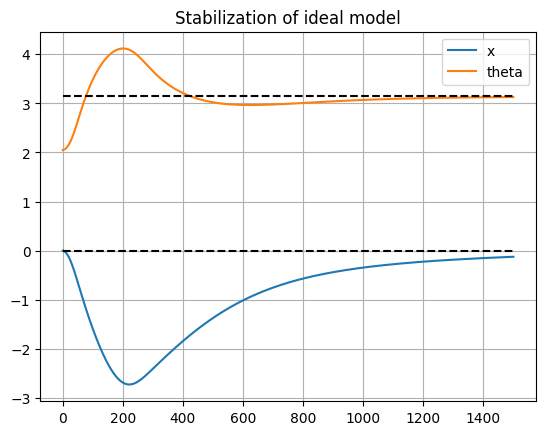

In [ ]:
import matplotlib.pyplot as plt

qhist = np.array(qhist)
plt.title("Stabilization of ideal model")
plt.plot(qhist[:, 0], label="x")
plt.plot(qhist[:, 1], label="theta")

plt.hlines(0, 0, len(qhist), color="black", linestyle="--")
plt.hlines(np.pi, 0, len(qhist), color="black", linestyle="--")

plt.grid()
plt.legend()
plt.show()

### Introducing Uncertainty

let us alter dynamical parameters of the cart-pole as if we were unsure of them and made a some guess


In [ ]:
# create a model with uncertainty, with the same structure as the original model
uncertain_model = mjcf.from_path(CART_POLE_MJCF)
# change the mass of the cart
cart = uncertain_model.find("body", "cart")
cart.inertial.mass = 1  # from 0.5 to 1.0

# change the mass of the pole
pole = uncertain_model.find("body", "pole")
pole.inertial.mass = 0.5  # from 0.1 to 0.5
# change the length of the pole
pole.inertial.pos[2] = -0.9  # from -0.5 to -0.9

# create a model with uncertainty
uncertain_model = mjcf.Physics.from_mjcf_model(uncertain_model).model._model
uncertain_data = mujoco.MjData(uncertain_model)

ctrl0, K = compute_gains(uncertain_model, uncertain_data, target, Q, R)

# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)
sim_data.qpos = qpos0

qhist_uncertain = []

while sim_data.time < DURATION:
    # Get state difference dx.
    mujoco.mj_differentiatePos(sim_model, dq, 1, target, sim_data.qpos)
    dx = np.hstack((dq, sim_data.qvel)).T

    # LQR control law.
    sim_data.ctrl = ctrl0 - K @ dx + np.random.randn(sim_model.nu) * BALANCE_STD

    # Step the simulation.
    mujoco.mj_step(sim_model, sim_data)

    # Save history.
    qhist_uncertain.append(sim_data.qpos.copy())

[0. 0.]


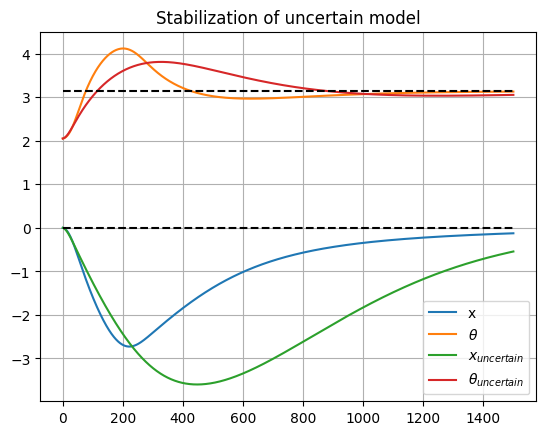

In [ ]:
import matplotlib.pyplot as plt

qhist_uncertain = np.array(qhist_uncertain)
plt.title("Stabilization of uncertain model")
plt.plot(qhist[:, 0], label="x")
plt.plot(qhist[:, 1], label="$\\theta$")
plt.plot(qhist_uncertain[:, 0], label="$x_{uncertain}$")
plt.plot(qhist_uncertain[:, 1], label="$\\theta_{uncertain}$")

plt.hlines(0, 0, len(qhist), color="black", linestyle="--")
plt.hlines(np.pi, 0, len(qhist), color="black", linestyle="--")

plt.grid()
plt.legend()
plt.show()

It is obvious that even though cart pole with uncertain model can still balance the pole, the controller performance is far from that provided by original LQR controller.

In order to tackle this problem, we will try to identify the actual parameters of the cart pole system.

### Cart Pole Identification

Now let us build the identification routine, we will perfrom the several steps: this by gather data from the uncertain model and use it to identify the system dynamics. Then, we can design a controller based on the identified model.

#### Data gathering via random forcing

We begin with gathering the data by randomly applying force to the cart:

In [ ]:
# random forcing and measure data

# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)

identification_data = {
    "qhist": [],
    "vhist": [],
    "dvhist": [],
    "uhist": [],
}

for i in range(3000):
    identification_data["qhist"].append(sim_data.qpos.copy())
    identification_data["vhist"].append(sim_data.qvel.copy())

    u = np.random.randn(1) * 10
    identification_data["uhist"].append(u)

    sim_data.ctrl = u
    mujoco.mj_step(sim_model, sim_data)
    identification_data["dvhist"].append(sim_data.qacc.copy())

identification_data["qhist"] = np.array(identification_data["qhist"])
identification_data["vhist"] = np.array(identification_data["vhist"])
identification_data["dvhist"] = np.array(identification_data["dvhist"])
identification_data["uhist"] = np.array(identification_data["uhist"])

#### Formulate regressors of system dynamics

Once data is gathered we can formulate the sys-id problem, to do so we will dig into structure of problem at hand by recalling that dynamics of cart pole system is given by:

$$
\begin{equation}
\begin{cases}
\left(M+m\right){\ddot {q}_1}-m L \ddot{q}_2 \cos q_2 +m L \dot{q}_2^{2}\sin q_2 = u \\
L \ddot{q}_2- g\sin q_2 =\ddot{q}_1 \cos q_2 \\
\end{cases}
\end{equation}
$$

where $q_2$ is angle of the pendulum measured from the upper equilibrium and $q_1$ is position of cart.





The notable property of any rigid body mechanical system  (cart-pole in particaluar that) the inverse dynamics [can be parametrized linearly to the set of constant inertial parameters](https://journals.sagepub.com/doi/abs/10.1177/027836498600500306?journalCode=ijra), indeed one may introduce the parameters $\boldsymbol{\theta} = [M+m, mL, L]$ and derive linearly parametrized inverse dynamics in so called regressor form:

$$
\begin{bmatrix}
\ddot{q}_1 & - \ddot{q}_2 \cos \theta + \dot{q}_2^2 \sin q_2 & 0 \\
0 & 0 & \ddot{q}_2 \\
\end{bmatrix} \begin{bmatrix}
M + m \\
mL \\
L
\end{bmatrix} = \begin{bmatrix}
u \\
g \sin q_2 + \ddot{q}_1 \cos q_2 \\
\end{bmatrix}
$$

For given measurements of $\mathbf{q}(t), \dot{\mathbf{q}}(t), \ddot{\mathbf{q}}(t), \mathbf{u}(t)$ the above is the formulated as simple linear equation:
:
$$
\mathbf{A}(t)\boldsymbol{\theta} = \mathbf{b}(t)
$$

Now given the sequance of time samples we may build the $\mathbf{A}, \mathbf{b}$ and solve associated linear least squares problem (posibly with bounds on parameters):

In [ ]:
# formulate regressor
A = []
b = []

g = 9.81

for i in range(1, len(qhist)):
    q = identification_data["qhist"][i]
    v = identification_data["vhist"][i]
    dv = identification_data["dvhist"][i]
    u = identification_data["uhist"][i]

    regressor = [
        [dv[0], -dv[1] * np.cos(q[1]) + v[1] ** 2 * np.sin(q[1]), 0],
        [0, 0, dv[1]],
    ]

    A.extend(regressor)
    b.extend(
        [
            u[0],
            dv[0] * np.cos(q[1]) + g * np.sin(q[1]),
        ]
    )

A = np.array(A)
b = np.array(b)

#### Solving Least Squares problem:

Once the regressor matrix is gathered we may solve the simple leas squares problem to get the parameter estimates:

In [ ]:
import mujoco.minimize as minimize


def residual(x):
    # Ensure x is 2D for consistent processing
    if x.ndim == 1:
        x = x[:, np.newaxis]

    # Compute residuals using matrix operations
    return A @ x - b[:, np.newaxis]


result = minimize.least_squares(
    np.array((0.0, 0.0, 0.0)),
    residual,
)

identified_parameters = result[0]

newL = identified_parameters[2]
new_poleM = identified_parameters[1] / newL
new_cartM = identified_parameters[0] - new_poleM

print(newL)
print(new_poleM)
print(new_cartM)
identified_parameters


iter: 0    y: 3.606e+05  log10mu: -inf  ratio: 1        dx: 0.77     reduction: 3.4e+05
iter: 1    y: 2.238e+04  log10mu: -inf  ratio: 3.2e+07  dx: 3.1e-12  reduction: 3.6e-12
Terminated after 1 iterations: norm(dx) < tol. y: 2.238e+04, Residual evals: 9
total time 5.4ms of which residual 10.1%
0.47978147158813766
0.10421411196461379
0.4957858880325568


array([0.6 , 0.05, 0.48])

### LQR on Identified System

Ones parameters are identified we will build a new model and perform an updated LQR on identified system:

In [ ]:
# create a model with identified parameters, with the same structure as the original model
identified_model = mjcf.from_path(CART_POLE_MJCF)
# change the mass of the cart
cart = identified_model.find("body", "cart")
cart.inertial.mass = new_cartM

# change the mass of the pole
pole = identified_model.find("body", "pole")
pole.inertial.mass = new_poleM
# change the length of the pole
pole.inertial.pos[2] = -newL

# create a model with uncertainty
identified_model = mjcf.Physics.from_mjcf_model(identified_model).model._model
identified_data = mujoco.MjData(identified_model)

ctrl0, K = compute_gains(identified_model, identified_data, target, Q, R)

# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)
sim_data.qpos = qpos0

qhist_identified = []

while sim_data.time < DURATION:
    # Get state difference dx.
    mujoco.mj_differentiatePos(sim_model, dq, 1, target, sim_data.qpos)
    dx = np.hstack((dq, sim_data.qvel)).T

    # LQR control law.
    sim_data.ctrl = ctrl0 - K @ dx + np.random.randn(sim_model.nu) * BALANCE_STD

    # Step the simulation.
    mujoco.mj_step(sim_model, sim_data)

    # Save history.
    qhist_identified.append(sim_data.qpos.copy())

[0. 0.]


# Online parameter estimation using RLS:

In [ ]:
import numpy as np
import mujoco
import scipy.linalg
#online parameter estimation using RLS

theta_est = np.array([0.1, 0.1, 0.1])  # Initial guess for [M+m, mL, L]
P = np.eye(3) * 1000  # Initial covariance

def update_parameters_RLS(A, b, theta_est, P, gamma=0.5): # need to change

    """
    Update parameters using Recursive Least Squares (RLS).

    Parameters:
    - A: Regressor matrix (1 x 3)
    - b: Output vector (1 x 1)
    - theta_est: Current parameter estimates (3 x 1)
    - P: Covariance matrix (3 x 3)
    - gamma: Forgetting factor

    Returns:
    - Updated parameter estimates
    - Updated covariance matrix
    """
    A = A.reshape(1, -1)
    b = b.reshape(-1, 1)

    # Gain calculation
    S = A @ P @ A.T + gamma
    K = P @ A.T @ np.linalg.inv(S)
    # Update estimates
    theta_est += (K @ (b - A @ theta_est)).flatten()
    P = (P - K @ A @ P) / gamma
    return theta_est, P

def compute_gains_with_estimates(model, data, theta_est, configuration, Q, R):
    M_plus_m, mL, L = theta_est

    # Update model parameters online
    model.body_mass[1] = M_plus_m  # Update the mass of the cart
    model.body_mass[2] = mL / L    # Update the mass of the pole

    # Set configuration and find control that stabilizes it (ctrl0)
    newdata = mujoco.MjData(model)
    newdata = copy.copy(data)

    mujoco.mj_resetData(model, newdata)
    newdata.qpos = configuration
    mujoco.mj_forward(model, newdata)
    newdata.qacc = 0
    mujoco.mj_inverse(model, newdata)

    # Define control and configuration to linearize around
    ctrl0 = newdata.qfrc_inverse.copy() @ np.linalg.pinv(newdata.actuator_moment)
    qpos0 = newdata.qpos.copy()

    # Compute LQR gains given weights
    mujoco.mj_resetData(model, newdata)
    newdata.ctrl = ctrl0
    newdata.qpos = qpos0

    # Allocate the A and B matrices, compute them
    A = np.zeros((2 * model.nv, 2 * model.nv))
    B = np.zeros((2 * model.nv, model.nu))
    epsilon = 1e-6
    flg_centered = True
    mujoco.mjd_transitionFD(model, newdata, epsilon, flg_centered, A, B, None, None)

    # Solve discrete Riccati equation
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # Compute the feedback gain matrix K
    K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

    return ctrl0, K


# Simulation parameters
DURATION = 3  # seconds
UPDATE_INTERVAL = 0.1

dq = np.zeros(sim_model.nv)
qpos0 = np.array([0, 2.05])
target = np.array([0, np.pi])

Q = np.diag([1, 1, 1, 1]) * 1e2
R = np.eye(sim_model.nu)

ctrl0, K = compute_gains(sim_model, sim_data, target, Q, R)

# Reset data, set initial pose
mujoco.mj_resetData(sim_model, sim_data)
sim_data.qpos = qpos0

qhist_identified = []
last_update_time = 0


while sim_data.time < DURATION:
    # Get state difference dx
    mujoco.mj_differentiatePos(sim_model, dq, 1, target, sim_data.qpos)
    dx = np.hstack((dq, sim_data.qvel)).T

    # LQR control law
    sim_data.ctrl = ctrl0 - K @ dx + np.random.randn(sim_model.nu)

    # Step the simulation
    mujoco.mj_step(sim_model, sim_data)

    # Save history
    qhist_identified.append(sim_data.qpos.copy())

    # Online parameter estimation
    q = sim_data.qpos
    qd = sim_data.qvel
    qdd = sim_data.qacc
    u = sim_data.ctrl
    # Construct A(t) and b(t)
    A_t = np.array([[qdd[0], -qdd[1] * np.cos(q[1]) + qd[1]**2 * np.sin(q[1]), 0]])
    b_t = np.array([u - (qdd[1] * np.sin(q[1]) + qdd[0] * np.cos(q[1]))])

    # Update parameters
    theta_est, P = update_parameters_RLS(A_t, b_t, theta_est, P)
    # Update control gains periodically
    if sim_data.time - last_update_time > UPDATE_INTERVAL:
        ctrl0, K = compute_gains_with_estimates(sim_model, sim_data, theta_est, target, Q, R)
        last_update_time = sim_data.time

print("Final parameter estimates: ", theta_est)


[0. 0.]


<ipython-input-14-629a076e9858>:32: RuntimeWarning: overflow encountered in divide
  P = (P - K @ A @ P) / gamma
<ipython-input-14-629a076e9858>:28: RuntimeWarning: invalid value encountered in matmul
  S = A @ P @ A.T + gamma
<ipython-input-14-629a076e9858>:29: RuntimeWarning: invalid value encountered in matmul
  K = P @ A.T @ np.linalg.inv(S)
Exception ignored on calling ctypes callback function: <function _warning_callback at 0x7df6c9d5bd90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/dm_control/mujoco/wrapper/core.py", line 64, in _warning_callback
    logging.warning(util.to_native_string(message))
  File "/usr/local/lib/python3.10/dist-packages/absl/logging/__init__.py", line 397, in warning
    log(WARNING, msg, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/absl/logging/__init__.py", line 556, in log
    _absl_logger.log(standard_level, msg, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/absl/logging/__

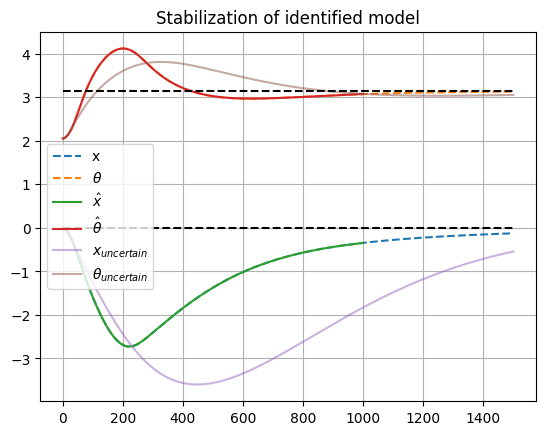

In [ ]:
import matplotlib.pyplot as plt

qhist_identified = np.array(qhist_identified)
plt.title("Stabilization of identified model")
plt.plot(qhist[:, 0], label="x", linestyle="--")
plt.plot(qhist[:, 1], label="$\\theta$", linestyle="--")
plt.plot(qhist_identified[:, 0], label="$\hat{x}$")
plt.plot(qhist_identified[:, 1], label=r"$\hat{\theta}$")
plt.plot(qhist_uncertain[:, 0], label="$x_{uncertain}$", alpha=0.5)
plt.plot(qhist_uncertain[:, 1], label=r"$\theta_{uncertain}$", alpha=0.5)

plt.hlines(0, 0, len(qhist), color="black", linestyle="--")
plt.hlines(np.pi, 0, len(qhist), color="black", linestyle="--")

plt.grid()
plt.legend()
plt.show()

as one can see the estimated feedback gains provided by identified parameters result in the response that is very similar to the original on thus seggesting the good estimation accuracy.



## The Building Blocks of System Identification
Despite the simplicity of the cart-pole system, it serves as a useful starting point, as it encompasses the main building blocks that are consistently used in most system identification applications. These building blocks include:

1. **Model Parametrization**: The first step involves constructing a parametrized model of the system, particularly a linear one. This parametrization captures the essential characteristics and dynamics of the system in a concise and manageable form.

2. **Data Acquisition**: To identify the system parameters, it is necessary to gather data by applying specific forcing or excitation to the system. In the case of the cart-pole example, random forcing was used to generate informative data that captures the system's behavior under various conditions.

3. **Least Squares Estimation**: With the obtained data, the next step is to formulate and solve a least squares problem. This involves minimizing the difference between the predicted outputs of the parametrized model and the actual measured outputs from the system. By solving the least squares problem, the optimal estimates of the system parameters can be determined.

4. **Parameter Verification**: Once the system parameters have been estimated, it is crucial to verify their validity and performance in a particular scenario. This verification step ensures that the identified parameters accurately represent the system's behavior and can be used for control or other purposes.

These building blocks form the foundation of system identification and are applicable to a wide range of systems, from simple toy problems to complex real-world applications for control, simulation, or analysis purposes.

Having explored the basics of system identification through the cart-pole example, let us now move on to a more practical and challenging application: the load extimation on Panda manipulator.

## Panda Load Estimation and Compensation



Let's delve into a more hands-on challenge involving the [Panda manipulator](https://github.com/google-deepmind/mujoco_menagerie/tree/main/franka_emika_panda#readme). Suppose the manipulator has securely grasped an object, the mass and offset of which from the end-effector are unknown. The goal is to ascertain these parameters by guiding the robot through a sequence of predetermined configurations and monitoring the corresponding changes in torque.

Once these parameters are precisely determined, we can proceed to compensate for the external load by updating the control policy.

#### Actuator Type

Before progressing, it is crucial to set up all actuators for torque control. This configuration can be efficiently achieved by modifying the [actuator type](https://github.com/lvjonok/mujoco-actuators-types):

In [ ]:
from robot_descriptions.panda_mj_description import MJCF_PATH

# get path to panda without gripper
MJCF_PATH = MJCF_PATH[: -len("panda.xml")] + "panda_nohand.xml"

np.random.seed(0)

In [ ]:
class ActuatorMotor:
    def __init__(self) -> None:
        self.dyn = np.array([1, 0, 0])
        self.gain = np.array([1, 0, 0])
        self.bias = np.array([0, 0, 0])

    def __repr__(self) -> str:
        return f"ActuatorMotor(dyn={self.dyn}, gain={self.gain}, bias={self.bias})"


def update_actuator(model, actuator_id, actuator):
    """
    Update actuator in model
    model - mujoco.MjModel
    actuator_id - int or str (name) (for reference see, named access to model elements)
    actuator - ActuatorMotor, ActuatorPosition, ActuatorVelocity
    """

    model.actuator(actuator_id).dynprm[:3] = actuator.dyn
    model.actuator(actuator_id).gainprm[:3] = actuator.gain
    model.actuator(actuator_id).biasprm[:3] = actuator.bias
    model.actuator(actuator_id).ctrlrange = None

### Modifying the Model and Adding Load

To facilitate our discussion, we will work with two distinct models. The `old_model` will represent the configuration without any load, whereas the `sim_model` will include a mass attached to the end effector (`link_7`).

Additionally, to avoid complications during simulations, particularly as we will be working with randomly selected desired points in joint space, we will disable all self-collisions. This precaution helps prevent excessive joint torques that can arise from self-collisions.

In [ ]:
# create a model with external load
mjcf_model = mjcf.from_path(MJCF_PATH, escape_separators=True)
# get the body of end-effector
ee_body = mjcf_model.find("body", "link7")
# create new body with offset from the end-effector
rc = np.array([0.1, 0.05, -0.1])
load_mass = ee_body.add("body", name="load_mass", pos=f"{rc[0]} {rc[1]} {rc[2]}")
load_mass.add("geom", name="load_mass_geom", type="sphere", size="0.05", rgba="0.8 0.2 0.2 1")

# add inertial properties to the new body
M = 2.0
I = 1e-6
load_mass.add("inertial", mass=f"{M}", pos="0 0 0", diaginertia=f"{I} {I} {I}")

# disable collision for all the geoms
for geom in mjcf_model.find_all("geom"):
    geom.conaffinity = 0
    geom.contype = 0

physics = mjcf.Physics.from_mjcf_model(mjcf_model)
sim_model = physics.model._model
sim_data = mujoco.MjData(sim_model)
renderer = mujoco.Renderer(sim_model, height=480, width=640)

# create an old model without the load mass
old_mjcf_model = mjcf.from_path(MJCF_PATH, escape_separators=True)
# disable collisions for all the geoms
for geom in old_mjcf_model.find_all("geom"):
    geom.conaffinity = 0
    geom.contype = 0

old_model = mjcf.Physics.from_mjcf_model(old_mjcf_model).model._model
old_data = mujoco.MjData(old_model)
body_offset = np.where(old_model.body_dofadr == 0)[0][0]

# update actuator type
for actuator_id in range(sim_model.nu):
    actuator = ActuatorMotor()
    update_actuator(sim_model, actuator_id, actuator)

To better understand the changes and dynamics, we will visually represent the `sim_model` that includes the external load attached to the end effector (`link_7`):

In [ ]:
# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)

# Step the simulation.
mujoco.mj_step(sim_model, sim_data)

renderer.update_scene(sim_data)
media.show_image(renderer.render())

### Parametrizing the Model with External Load

We begin with deriving external force and torque produced by the load on end effector local frame, the load is given by:
$$
m a_g = f_{ee}
$$
while the torque
$$
ma_g\times r = \tau_{ee}
$$

Here, $a_g$ is the acceleration due to gravity, specifically $a_g = R^T \begin{bmatrix} 0 & 0 & 9.81 \end{bmatrix}^T$ where $R$ is the rotation matrix of the end-effector.

Thus external load can be parametrized using four parameters: mass $m$, and the first moment, i.e mass multiplied by its CoM position: $mr_x, mr_y, mr_z$. The linear parametrization of the static force exerted by the load can be represented as:

$$
\begin{bmatrix}
a_1 & 0 & 0 & 0 \\
a_2 & 0 & 0 & 0 \\
a_3 & 0 & 0 & 0 \\
0 & 0 & a_3 & -a_2 \\
0 & -a_3 & 0 & a_1 \\
0 & a_2 & -a_1 & 0
\end{bmatrix}
\begin{bmatrix}
m \\
mr_x \\
mr_y \\
mr_z
\end{bmatrix} = \begin{bmatrix}
f_{ee} \\
\tau_{ee} \\
\end{bmatrix}
$$

This matrix equation can be compactly expressed in matrix-vector notation as:

$$
\mathbf{Y_b} \theta = \bar{f}
$$

where $\mathbf{Y_b}$ is the matrix composed of gravitational components and cross-product terms, and $\theta$ encapsulates the inertial parameters.

The implementation of the above regressor yields:

In [ ]:
def static_body_regressor(
    mj_model: mujoco.MjModel, mj_data: mujoco.MjData, body_id: int, body_offset: int = 0
) -> np.ndarray:
    """Calculates the static body regressor matrix for a given body.

    Args:
        mj_model (mujoco.MjModel): MuJoCo model.
        mj_data (mujoco.MjData): MuJoCo data.
        body_id (int): ID of the body.
        body_offset (int, optional): Offset for the body ID. Defaults to 0.

    Returns:
        np.ndarray: Static body regressor matrix of shape (6, 4).
    """

    # mujoco.mj_kinematics(mj_model, mj_data)
    rotation = mj_data.xmat[body_id + body_offset].reshape(3, 3).copy()

    a1, a2, a3 = rotation.T @ np.array([0, 0, 9.81])

    static_load_regressor = np.array(
        [
            [a1, 0, 0, 0],
            [a2, 0, 0, 0],
            [a3, 0, 0, 0],
            [0, 0, a3, -a2],
            [0, -a3, 0, a1],
            [0, a2, -a1, 0],
        ]
    )

    return static_load_regressor


Transitioning to a focus on practical application, it is beneficial to reformulate the load model in terms of motor torques (commonly derived from motor currents). This reorientation leads us back to the inverse dynamics:

$$
M(q) \ddot{q} + C(q, \dot{q}) \dot{q} + g(q) = \tau - J^T(q) \bar{f}
$$

Here, $M(q)$ is the mass matrix, $C(q, \dot{q})$ is the Coriolis matrix, $G(q)$ is the gravitational force vector, and $\tau$ represents the joint torques. In the absence of external loads and other applied wrenches, the last term would be omitted.

In static conditions ($\ddot{q} = 0, \dot{q} = 0$) and substituting $\bar{f} = \mathbf{Y_b} \theta$, we derive:

$$
g(q) = \tau - J^T(q) \mathbf{Y}_b(q) \theta
$$

The term $\mathbf{Y}_s(q) = J^T(q)\mathbf{Y}_b(q) \theta$, henceforth referred to as the joint regressor (for statics), illustrates how the end-effector load, parametrized linearly in terms of the load's mass and CoM, contributes to joint torques in static conditions.

In [ ]:
def static_joint_regressor(
    mj_model: mujoco.MjModel, mj_data: mujoco.MjData, body_id: int, active_joints: int = 7, body_offset: int = 0
) -> np.ndarray:
    """Calculates the static joint regressor matrix for a given body.

    Args:
        mj_model (mujoco.MjModel): MuJoCo model.
        mj_data (mujoco.MjData): MuJoCo data.
        body_id (int): ID of the body.
        active_joints (int, optional): Number of active joints. Defaults to 7.
        body_offset (int, optional): Offset for the body ID. Defaults to 0.

    Returns:
        np.ndarray: Static joint regressor matrix of shape (active_joints, 4).
    """
    accel = np.zeros(6)

    mujoco.mj_rnePostConstraint(mj_model, mj_data)
    mujoco.mj_objectAcceleration(mj_model, mj_data, 2, body_id, accel, 1)

    static_load_regressor = static_body_regressor(mj_model, mj_data, body_id, body_offset)
    rotation = mj_data.xmat[body_id + body_offset].reshape(3, 3).copy()

    jac_lin = np.zeros((3, mj_model.nv))
    jac_rot = np.zeros((3, mj_model.nv))
    mujoco.mj_jacBody(mj_model, mj_data, jac_lin, jac_rot, body_id + body_offset)
    ee_local_jacobian = np.vstack(
        (
            rotation.T @ jac_lin[:, :active_joints],
            rotation.T @ jac_rot[:, :active_joints],
        )
    )
    joint_regressor = ee_local_jacobian.T @ static_load_regressor

    return joint_regressor

For practical implementation, see the code available in this [GitHub repository](https://github.com/lvjonok/mujoco-sysid/blob/master/mujoco_sysid/modeling.py), which demonstrates how to integrate more general case of full inertial parameters using the Mujoco `mj_data`. We will undertake similar exercises in subsequent examples.

### Load Estimation

With the foundational concepts established, we are now equipped to initiate the main load estimation routine. The methodology will be structured as follows:

1. **Joint Space Regulation:** Initially, we will control the manipulator to achieve a sequence of random points in joint space. This control will be executed using the inverse dynamics of an uncertain model.

2. **Data Collection during Steady State:** After allowing sufficient time for the transients to settle at each target point, we will record the applied torques. Concurrently, we will calculate the joint regressors, which are crucial for the next steps of load estimation.

3. **Least Squares Estimation:** With the collected data, we will employ a least squares method to estimate the load's mass and center of mass (CoM).

4. **Model Compensation and Verification:** After estimating the load parameters, we will update the control policy to compensate for the identified load and verify the accuracy of our estimates.


First we generate random points in joint space.

In [ ]:
# find limits except the last two fingers
lower, upper = np.zeros(sim_model.nq), np.zeros(sim_model.nq)
for jnt_idx in range(sim_model.nq):
    lower[jnt_idx] = sim_model.joint(jnt_idx).range[0]
    upper[jnt_idx] = sim_model.joint(jnt_idx).range[1]

num_of_phases = 3
waypoints = [np.random.uniform(lower, upper) for _ in range(num_of_phases)]

#### Controller Implementation on Approximate Dynamics and Data Collection

To ensure stability at each targeted joint position, we will employ a basic inverse dynamics controller defined by the following equation:

$$
u = M_0(q) (K_p\tilde{q} - K_d\dot{q} ) + C_0(q, \dot{q}) \dot{q} + g_0(q)
$$

It is important to note that this controller does not account for the load, as it relies solely on the nominal model parameters (`old_model`), indicated by the subscripts $M_0, C_0, g_0$. Consequently, the controller might not achieve zero tracking error. Additionally, the control input $u$ is applied to the actual uncertain model (`sim_model`), meaning the generalized angles and velocities reflect the real system conditions, designated as `old_data = sim_data`.

Whenever the manipulator approximately reaches the desired point and the transient dynamics have settled, we will capture the regressor matrix along with the torque differences, which are formulated as:

$$
u - g_0(q) =  \mathbf{Y}(q) \theta
$$

This relationship facilitates the segregation of the dynamic effects solely influenced by the load:

In [ ]:
# define PD controller for inverse dynamics
kp = 50
kd = 10
target_q = waypoints[0]

frames = []
framerate = 25

phase_time = 5.0
phases = 0
old_data.time = 0
sim_data.time = 0

load_joint_regressor = np.zeros(((sim_model.nq) * num_of_phases, 4))
load_joint_force = np.zeros((sim_model.nq) * num_of_phases)
active_joints = sim_model.nq

hist_q = []
target_hist_q = []

while sim_data.time < (num_of_phases - 1) * phase_time:
    # PD controller
    mujoco.mj_step(sim_model, sim_data)

    hist_q.append(sim_data.qpos.copy())
    target_hist_q.append(target_q)

    target_acc = kp * (target_q - sim_data.qpos) + kd * (np.zeros(sim_model.nv) - sim_data.qvel)

    # use old data to solve inverse dynamics
    old_data.qpos = sim_data.qpos.copy()
    old_data.qvel = sim_data.qvel.copy()
    old_data.qacc = target_acc
    mujoco.mj_inverse(old_model, old_data)
    sol = old_data.qfrc_inverse

    sim_data.ctrl = sol

    if sim_data.time > phase_time * phases and phases < num_of_phases:
        # after each phase we add the regressor and the joint forces
        # and change the target q
        regressor = static_joint_regressor(old_model, old_data, old_data.body(ee_body.name).id).copy()

        load_joint_regressor[7 * phases : 7 * (phases + 1), :] = regressor

        load_qforce = sol[:7] - old_data.qfrc_bias[:7]
        load_joint_force[7 * phases : 7 * (phases + 1)] = load_qforce.copy()
        actual_load_qforce = regressor @ np.array([M, *(M * rc)])

        target_q = waypoints[phases]
        phases += 1

hist_q = np.array(hist_q)
target_hist_q = np.array(target_hist_q)

The plot below illustrates that the errors are not zero, indicating that the robot struggles to accurately reach the desired waypoints. This deviation from the expected positions is a predictable outcome, given the controller's inability to account for additional external forces:

In [ ]:
each_joint_color = ["r", "g", "b", "c", "m", "y", "k"]

plt.figure(figsize=(10, 5))
plt.title("Joint positions")
for jidx in range(7):
    plt.plot(hist_q[:, jidx], color=each_joint_color[jidx])
    plt.plot(target_hist_q[:, jidx], linestyle="--", color=each_joint_color[jidx])

plt.grid()
plt.show()

#### Building and solving least sqaures

Having collected the necessary data, we can now proceed to structure this information into a system of equations suitable for least squares analysis. Each data point collected gives us an equation based on the deviation from the control input due to the unmodeled load:

$$
u - g_0(q) = \Delta u_i = \mathbf{Y}_i(q_i) \theta
$$

Here, the subscript $i$ signifies the specific data point recorded. These individual equations are then compiled into larger matrices:

$$
\begin{bmatrix}
\mathbf{Y}_1 \\
\mathbf{Y}_2 \\
\vdots \\
\mathbf{Y}_N
\end{bmatrix} \theta = \begin{bmatrix}
\Delta u_1 \\
\Delta u_2 \\
\vdots \\
\Delta u_N
\end{bmatrix}
$$

This sets the stage for the least squares estimation, where the tall matrix on the left contains the stacked regressor matrices $\mathbf{Y}_i$ for each point $i$, and the vector on the right consists of the corresponding torque deviations $\Delta u_i$:

In [ ]:
def manip_load_ls(x):
    # Ensure x is 2D for consistent processing
    if x.ndim == 1:
        x = x[:, np.newaxis]

    # Compute residuals using matrix operations
    return load_joint_regressor[7:] @ x - load_joint_force[7:][:, np.newaxis]

This initial point typically  (first 7 elements) is subject to sudden changes in acceleration and velocities due to the initial response of the PD controller. These abrupt dynamics can introduce significant noise and anomalies, potentially leading to inaccurate estimations if included in our model, thus we ignore it above.

Now, we move forward to solve the associated least squares problem and will also print out the load parameters for reference:

In [ ]:
M, rc

In [ ]:
import mujoco.minimize as minimize

result = minimize.least_squares(
    np.ones(4),  # Initial guess for the parameter values
    manip_load_ls,
)
load_estimates = result[0]
print(load_estimates)

From these estimates, we can parse the actual center of mass position:

In [ ]:
mass = load_estimates[0]
coordinate = load_estimates[1:] / mass
print(mass, coordinate)

As observed, the estimates are remarkably close to the actual external load. It's worth noting that this problem is fundamentally a linear least squares, which can be resolved using the simple pseudoinverse method:

In [ ]:
load_pinv_estimates = np.linalg.pinv(load_joint_regressor[7:, :]) @ load_joint_force[7:]
mass_pinv = load_pinv_estimates[0]
coordinate_pinv = load_pinv_estimates[1:] / mass
mass_pinv, coordinate_pinv

However, if one wants to account for bounds on the parameters, nonlinear dependencies such as friction models, or physical consistency, it is advisable to utilize a more general framework provided by minimize.least_squares.

#### Verifying and Utilizing the Estimated Load
To verify and utilize the estimated load parameters effectively, we can modify our control policy to include the estimated parameters.

This adjustment involves adding an additional term to the inverse controller:
$$
u = M_0(q) (K_p\tilde{q} - K_d\dot{q} ) + C_0(q, \dot{q}) \dot{q} + g_0(q) + \mathbf{Y}(q) \hat{\theta}
$$


In [ ]:
# define PD controller for inverse dynamics
kp = 50
kd = 10
target_q = waypoints[0]

frames = []
framerate = 25

phase_time = 5.0
phases = 0
old_data.time = 0
sim_data.time = 0

load_joint_regressor = np.zeros(((sim_model.nq) * num_of_phases, 4))
load_joint_force = np.zeros((sim_model.nq) * num_of_phases)
active_joints = sim_model.nq

hist_q_new = []
target_hist_q_new = []

while sim_data.time < (num_of_phases - 1) * phase_time:
    # PD controller
    mujoco.mj_step(sim_model, sim_data)

    hist_q_new.append(sim_data.qpos.copy())
    target_hist_q_new.append(target_q)

    target_acc = kp * (target_q - sim_data.qpos) + kd * (-sim_data.qvel)

    # use old data to solve inverse dynamics
    old_data.qpos = sim_data.qpos.copy()
    old_data.qvel = sim_data.qvel.copy()
    old_data.qacc = target_acc
    mujoco.mj_inverse(old_model, old_data)
    sol = old_data.qfrc_inverse

    actual_load_qforce = (
        static_joint_regressor(old_model, old_data, old_data.body(ee_body.name).id).copy() @ load_estimates
    )

    sim_data.ctrl = sol + actual_load_qforce

    if sim_data.time > phase_time * phases and phases < num_of_phases:
        target_q = waypoints[phases]
        phases += 1

hist_q_new = np.array(hist_q_new)
target_hist_q_new = np.array(target_hist_q_new)

now let us plot the results of tracking (the updated model is given by solid lines):

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Joint positions after estimating load parameters")
for jidx in range(7):
    plt.plot(hist_q_new[:, jidx], color=each_joint_color[jidx])
    plt.plot(target_hist_q_new[:, jidx], linestyle="--", color=each_joint_color[jidx])
    plt.plot(hist_q[:, jidx], color=each_joint_color[jidx], alpha=0.5)

plt.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_title("Joints errors before estimating load parameters")
ax[0].plot(hist_q - target_hist_q, alpha=0.5)
ax[0].set_ylim(-1, 1)
ax[0].grid()

ax[1].set_title("Errors after compensation")
ax[1].plot(hist_q_new - target_hist_q_new, alpha=0.5)
ax[1].set_ylim(-1, 1)
ax[1].grid()

As we can see, the updated control law, which incorporates the estimated load parameters, significantly improves the accuracy of joint tracking. This improvement is evident from the decreased error in joint positions when compared to the target positions.



Up to now, our discussions have primarily focused on the static estimation of load parameters based on known inputs in joints, with a particular emphasis on regressor forms, which include both body and joint regressors. These concepts can be effectively extended to dynamic scenarios by utilizing adaptive control techniques, such as those found in [Slotine's adaptive controller](https://journals.sagepub.com/doi/abs/10.1177/027836498700600303) or its [recent modifications](https://ieeexplore.ieee.org/abstract/document/8593727). These techniques are designed to continuously adjust and optimize control parameters in real-time based on observed system behaviors.

However, before moving on to such advanced topics, let us first develop next regressors that will incorporate inertia parameters, starting with a simple single rigid body, specifically a model of a simple quadrotor.

## Quadrotor Inertia Identification




In the previous example, we considered estimating mass-related quantities, which were done basically through statics. However, some of the inertial parameters are not possible to extract under such circumstances; they inherently require active maneuvers.

This is the topic of the next example. Here, we will take into account the full system dynamics, including the inertia tensor:

$$
\mathbf{I} =\left[\begin{array}{lll}
I_{x x} & I_{x y} & I_{x z} \\
I_{x y} & I_{y y} & I_{y z} \\
I_{x z} & I_{y z} & I_{z z}
\end{array}\right]
$$

Note that the inertia tensor is represented in the body-fixed frame. Since the inertia tensor is symmetric, there are only $6$ unique parameters coming from this matrix. Adding mass and CoM position thus yields the following set of inertial parameters:

$$
\mathbf{\theta} = \begin{bmatrix} m, mr_x, mr_y, mr_z, I_{xx}, I_{xy}, I_{yy}, I_{xz}, I_{yz}, I_{zz} \end{bmatrix}^T
$$

Although these ten parameters are sufficient, they may not be the best possible set to represent the inertial properties of rigid bodies that are [tightly coupled with density distribution](https://arxiv.org/pdf/1701.04395). However, we will use these parameters as they are the most intuitive and easy to work with.

Our goal will be to estimate these ten parameters based on measurement data provided by a controlled Skydio X2 quadrotor:

In [ ]:
from robot_descriptions.skydio_x2_mj_description import MJCF_PATH

model = mujoco.MjModel.from_xml_path(MJCF_PATH[: -len("x2.xml")] + "scene.xml")
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, height=480, width=640)

for act_id in range(4):
    model.actuator(act_id).ctrlrange = np.array([-1e4, 1e4])

model.opt.timestep = 1e-3

In [ ]:
mujoco.mj_step(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

One may easily parse the inertial parameters $\theta$ from it's sparce spatial form M (here it is trivial since $M$ is fixed in local frame):

In [ ]:
sparceM = np.zeros((6, 6))

mujoco.mj_step(model, data)
mujoco.mj_fullM(model, sparceM, data.qM)

mSrc = sparceM[3:6, :3]
mrc = np.array([mSrc[2, 1], mSrc[0, 2], mSrc[1, 0]])
Ib = sparceM[3:6, 3:6]
vechIb = np.array([Ib[0, 0], Ib[0, 1], Ib[1, 1], Ib[0, 2], Ib[1, 2], Ib[2, 2]])
skydio_parameters = np.array([sparceM[0, 0], *mrc, *vechIb])

with np.printoptions(precision=3, suppress=True):
    print(skydio_parameters)

Now, let us treat these parameters as the true baseline and attempt to estimate them from one maneuver executed by the quadrotor. This process will involve several key steps:

* Simulate **the system response** under a specific controller (in this case, we will obtain an offline trajectory and perform Linear Quadratic Regulator (LQR) tracking). This step is designed to simulate the data coming from the actual quadrotor control system.

* Introduce the **full-body regressor** - a matrix that relates the inertial parameters to the measured data in a simple linear form.

* Formulate and solve the least squares problem based on the body regressor and compare the parameter estimates with true values.

#### LTV LQR Controller

Firstly, we will simulate the response of an actual control system by exploiting the LTV LQR technique. You may skip this step since it is not related to the problem at hand - estimating the model inertia. However, this example is useful on its own since LTV LQR is a widely used controller in practice. Below, we will introduce utility functions and some brief descriptions of the theory required to roughly understand time-varying LQR. For notation and more insight, please follow the original **LQR tutorial** <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/LQR.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="90"/></a>.



First we will load precomputed in advance desired trajectory:

In [ ]:
# load trajectory
traj = np.load("mujoco-sysid/data/trajectories/skydio.npz")
tf = traj["t"]

q_data = traj["q"].T
v_data = traj["v"].T
u_data = traj["u"].T
N_DATA = q_data.shape[1]
t_data = np.linspace(0, tf, N_DATA)

q_traj = scipy.interpolate.interp1d(t_data, q_data, axis=1, kind="linear")
v_traj = scipy.interpolate.interp1d(t_data, v_data, axis=1, kind="linear")
u_traj = scipy.interpolate.interp1d(t_data[:-1], u_data, axis=1, kind="linear")
N_TRAJ = int(tf / model.opt.timestep)
traj["q"].shape, traj["v"].shape, traj["u"].shape



**System Model**

For an LTV system, the state-space representation at each discrete time index $t$ is given by:

$$x_{t+1} = A_t x_t + B_t u_t$$

where $x_t$ is the state vector, $u_t$ is the control input, $A_t$ is the time-varying state transition matrix, and $B_t$ is the time-varying control input matrix.

**Linearization and Jacobian Matrices**

The matrices $A_t$ and $B_t$ represent the linearization of the system dynamics around a trajectory point at time $t$. They can be obtained by evaluating the Jacobian matrices of the nonlinear system function $f$ with respect to the state $x$ and control input $u$ at each point along the trajectory:

$$A_t = \frac{\partial f}{\partial x}\bigg|_{x_t, u_t}, \quad B_t = \frac{\partial f}{\partial u}\bigg|_{x_t, u_t}$$

This is why $A_t$ and $B_t$ are time-varying, as they depend on the specific trajectory point $(x_t, u_t)$ at each time step $t$

In [ ]:
def linearize(q: np.ndarray, v: np.ndarray, u: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Finds the linearization over a point.

    Args:
        q (np.ndarray): Generalized coordinates (positions).
        v (np.ndarray): Generalized velocities.
        u (np.ndarray): Control inputs.

    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing:
            - A (np.ndarray): State transition matrix of shape (2 * model.nv, 2 * model.nv).
            - B (np.ndarray): Control input matrix of shape (2 * model.nv, model.nu).
    """
    newdata = mujoco.MjData(model)
    newdata = copy.copy(data)

    mujoco.mj_resetData(model, newdata)
    newdata.ctrl = u
    newdata.qpos = q
    newdata.qvel = v

    # 4. Allocate the A and B matrices, compute them.
    A = np.zeros((2 * model.nv, 2 * model.nv))
    B = np.zeros((2 * model.nv, model.nu))
    epsilon = 1e-6  # model.opt.timestep
    flg_centered = False
    mujoco.mjd_transitionFD(model, newdata, epsilon, flg_centered, A, B, None, None)

    return A, B


**Cost Function**

The objective is to minimize a time-varying quadratic cost function over a finite horizon:

$$J = \sum_{t=0}^{T-1} (x_t^\top Q_t x_t + u_t^\top R_t u_t) + x_T^\top P_T x_T$$

Here, $Q_t$ and $R_t$ are symmetric positive definite matrices that may vary with time, and $P_T$ is the terminal cost matrix.

**Optimal Control Law**

The control law that minimizes the cost function $J$ is given by:

$$u_t^* = -K_t x_t$$

where $K_t$ are the optimal feedback gain matrices derived from the solution of the Riccati equation.

**Riccati Equation (LTV)**

The gain matrices $K_t$ and cost-to-go matrices $P_t$ are computed using a backward recursion through the Riccati equation:

$$P_t = Q + K_t^\top R K_t + (A_t - B_t K_t)^\top P_{t+1} (A_t - B_t K_t)$$

where the LQR gain $K_t$ is computed as:

$$K_t = (R + B_t^\top P_{t+1} B_t)^{-1} B_t^\top P_{t+1} A_t$$

starting from the terminal condition $P_{N-1} = Q$, this terminal condition may be calculated from steady state solution.

**Discrete Algebraic Riccati Equation (LTI)**

For an infinite horizon problem with constant system matrices $A$ and $B$, and cost matrices $Q$ and $R$, the steady-state solution $P$ can be determined by solving the Discrete Algebraic Riccati Equation (DARE):

$$P = Q + A^\top P A - A^\top P B (R + B^\top P B)^{-1} B^\top P A$$

The LQR gain $K$ is then computed as:

$$K = (B^\top P B + R)^{-1} B^\top P A$$

In [ ]:
from scipy.linalg import solve_discrete_are as dare


def dlqr(A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Discrete time LTI LQR.

    Args:
        A (np.ndarray): State transition matrix of shape (n, n).
        B (np.ndarray): Control input matrix of shape (n, m).
        Q (np.ndarray): State cost matrix of shape (n, n).
        R (np.ndarray): Control cost matrix of shape (m, m).

    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing:
            - K (np.ndarray): LQR gain matrix of shape (m, n).
            - P (np.ndarray): Cost-to-go matrix of shape (n, n).
    """
    # Solve discrete Ricatti equation (DARE)
    P = dare(A, B, Q, R)
    # Compute the LQR gain
    K = np.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)
    return K, P


def dlqr_ltv(A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Discrete time LTV LQR controller.

    Args:
        A (np.ndarray): State transition matrices of shape (N, n, n).
        B (np.ndarray): Control input matrices of shape (N, n, m).
        Q (np.ndarray): State cost matrix of shape (n, n).
        R (np.ndarray): Control cost matrix of shape (m, m).

    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing:
            - K (np.ndarray): LQR gains of shape (N, m, n).
            - P (np.ndarray): Cost-to-go matrices of shape (N, n, n).
    """
    N = np.shape(A)[0]
    n = np.shape(A)[1]
    m = np.shape(B)[2]

    # Matrix to store cost-to-go
    P = np.zeros((N, n, n))
    P[-1] = Q
    # Matrix to store gains
    K = np.zeros((N, m, n))

    for k in range(N - 2, -1, -1):
        # Compute the LQR gain
        invM_k = np.linalg.inv(R + B[k].T @ P[k + 1] @ B[k])
        K[k] = invM_k @ B[k].T @ P[k + 1] @ A[k]
        Ac_k = A[k] - B[k] @ K[k]  # Update with difference Riccati equation
        # Compute cost-to-go matrix
        P[k] = Q + K[k].T @ R @ K[k] + Ac_k.T @ P[k + 1] @ Ac_k

    return K, P


**Feedback Gains and policy**

The feedback gains $K_t$ are computed as:

$$K_t = (R_t + B_t^\top P_{t+1} B_t)^{-1} B_t^\top P_{t+1} A_t$$

Now we may calculate the feedback gains:

In [ ]:
# linearize around trajectory
A_traj = []
B_traj = []

traj_t = traj["t"]

traj_dt = model.opt.timestep

for i in range(N_DATA):
    t = i * traj_dt
    A, B = linearize(q_traj(t), v_traj(t), u_traj(t))
    A_traj.append(A)
    B_traj.append(B)

Q = np.eye(2 * model.nv)
R = np.eye(4) * 0.3

# find gains for stabilization at the end
A_stab, B_stab = linearize(
    q_data[:, -1],
    np.zeros(model.nv),
    np.ones(4) * 1.325 * 9.81 / 4,
)
# find gains for stabilization at the end
K_stab, P_stab = dlqr(A_stab, B_stab, Q, R)
K, _ = dlqr_ltv(A_traj, B_traj, Q, R)

Now we are ready to simulate the controller behaviour with following feedback policy:

$$u = u_t -K_t (x - x_t)$$

where $x$ is the current state



In [ ]:
FRAMERATE = 20  # Hz

# store different in tangent space between configurations
dq = np.zeros(model.nv)

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = q_traj(0)
data.qvel = np.zeros(6)
last_time = 0
phase = 0

hist_qpos = []
hist_target_qpos = []

frames = []
k = 0

ltv_log = {
    "q": [],
    "v": [],
    "dv": [],
    "u": [],
}

while data.time < tf + 3.0:
    hist_qpos.append(data.qpos.copy())
    t = data.time

    k = int(t / (tf / N_DATA))

    if t < tf - 0.1:
        q_target = q_traj(t)
        v_target = v_traj(t)
        u_target = u_traj(t)

        # Get state difference dx.
        mujoco.mj_differentiatePos(model, dq, 1, q_target, data.qpos.copy())

        dv = data.qvel.copy() - v_target
        dx = np.hstack((dq, dv)).T

        # LQR control law.
        data.ctrl = u_target - K[k] @ dx
    else:
        # stabilize around the last configuration
        q_target = q_data[:, -1]
        v_target = np.zeros(model.nv)
        u_target = np.ones(4) * 1.325 * 9.81 / 4

        # Get state difference dx.
        mujoco.mj_differentiatePos(model, dq, 1, q_target, data.qpos.copy())

        dv = data.qvel.copy() - v_target
        dx = np.hstack((dq, dv)).T

        # LQR control law.
        data.ctrl = u_target - K_stab @ dx

    mujoco.mj_step(model, data)

    hist_target_qpos.append(q_target.copy())

    # extend the log
    ltv_log["q"].append(data.qpos.copy())
    ltv_log["v"].append(data.qvel.copy())
    ltv_log["dv"].append(data.qacc.copy())
    ltv_log["u"].append(data.ctrl.copy())

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera=0)
        pixels = renderer.render()
        frames.append(pixels)


ltv_log["q"] = np.array(ltv_log["q"])
ltv_log["v"] = np.array(ltv_log["v"])
ltv_log["dv"] = np.array(ltv_log["dv"])
ltv_log["u"] = np.array(ltv_log["u"])

media.show_video(frames, fps=framerate)

In [ ]:
hist_qpos = np.array(hist_qpos)
hist_target_qpos = np.array(hist_target_qpos)

plt.figure(figsize=(12, 6))
plt.title("Position tracking")
plt.plot(hist_qpos[:, :3], label=["x", "y", "z"])
plt.plot(hist_target_qpos[:, :3], linestyle="--")
plt.ylim([-5, 5])

plt.legend()
plt.grid()

plt.show()

#### Model Parametrization and Body Regressor

To effectively parametrize the model, we refer to the Newton-Euler formulation in spatial form, which is a pivotal concept in rigid body dynamics. If you need to recap this, refer to Roy Featherstone's book, ["Rigid Body Dynamics Algorithms"](https://link.springer.com/book/10.1007/978-1-4899-7560-7).

In a nutshell, the dynamics of a single rigid body is expressed as:

$$
M \mathrm{a}_{g} + \bar{v} \hat{\times} M \bar{v} = \bar{f}
$$

where:
- $M \in \mathbb{R}^{6 \times 6}$ is the spatial inertia matrix of the body,
$$
M=\left[\begin{array}{cc}
m 1_{3} & -m S(r_c)\\
m S(r_c) & I  
\end{array}\right]
$$

- $\bar{v} \in \mathbb{R}^6$ represents the spatial velocity,
- $\bar{f} \in \mathbb{R}^6$ is the external wrench applied,
- $g \in \mathbb{R}^{3}$ is the constant vector of gravity acceleration expressed with the orientation of the inertial frame $A$.

- $\mathrm{a}^{g} \in \mathbb{R}^{6}$ denotes the proper body acceleration, i.e., the difference between the body **spatial acceleration** and the gravity acceleration:  

$$
\mathrm{a}_{g}=\dot{\bar{\mathrm{v}}}-\left[\begin{array}{c}
{ }^{A} R_{B}^{\top} g \\
0_{3}  
\end{array}\right]
$$

- $\mathrm{v} \hat{\times}$ is the $6 \mathrm{D}$ cross product operator, defined as:

$$
\left[\begin{array}{l} v \\  
\omega
\end{array}\right] \hat{\times}=\left[\begin{array}{cc}
S(\omega) & 0_{3 \times 3} \\
S(v) & S(\omega)  
\end{array}\right]  
$$  



---



As one can see in the Inverse Dynamics (ID) for a single rigid body, there are only linear operations (multiplication with matrices) with respect to the spatial inertia matrix $M$. Thus, the force given by ID is **linearly parametrizable**:

$$
M \mathrm{a}_{g} + \bar{v} \hat{\times} M \bar{v} = \mathbf{Y}(\bar{v}, \mathrm{a}_{g})\boldsymbol{\theta} = \bar{f}
$$



---



where $\mathbf{Y}(\bar{v}, \mathrm{a}^{g}) \in \mathbb{R}^{6\times10}$ is the so-called **body regressor**.

The easiest way to obtain this matrix is to take the partial derivative of force $\bar{f}$ with respect to parameters $\boldsymbol{\theta}$, or just reparametrize cross products in a certain way. To shorten this, we provide handy notes on this topic in a Colab notebook <a href="https://colab.research.google.com/drive/1xFte2FT0nQ0ePs02BoOx4CmLLw5U-OUZ#scrollTo=MJEQtlpX0-Ya"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="90"/></a>. Consider studying it; later on, we will add more theoretical information there.

All in all, one may derive this linear parametrization and obtain the following equations for the body regressor:


In [ ]:
def mj_bodyRegressor(mj_model: mujoco.MjModel, mj_data: mujoco.MjData, body_id: int) -> np.ndarray:
    """
    Computes the body regressor matrix for a specific body in a MuJoCo model.

    Args:
        mj_model (mujoco.MjModel): MuJoCo model.
        mj_data (mujoco.MjData): MuJoCo data.
        body_id (int): ID of the body for which to compute the regressor matrix.

    Returns:
        np.ndarray: Body regressor matrix of shape (6, 10).
    """
    velocity = np.zeros(6)
    accel = np.zeros(6)
    _cross = np.zeros(3)

    mujoco.mj_objectVelocity(mj_model, mj_data, 2, body_id, velocity, 1)
    mujoco.mj_rnePostConstraint(mj_model, mj_data)
    mujoco.mj_objectAcceleration(mj_model, mj_data, 2, body_id, accel, 1)

    v, w = velocity[3:], velocity[:3]
    dv, dw = accel[3:], accel[:3]  # dv - classical acceleration, already contains g
    mujoco.mju_cross(_cross, w, v)
    dv -= _cross

    v1, v2, v3 = v
    v4, v5, v6 = w

    a1, a2, a3 = dv
    a4, a5, a6 = dw

    # fmt: off
    Y = np.array(
        [
            [a1 - v2 * v6 + v3 * v5, -(v5**2) - v6**2, -a6 + v4 * v5, a5 + v4 * v6, 0, 0, 0, 0, 0, 0],
            [a2 + v1 * v6 - v3 * v4, a6 + v4 * v5, -(v4**2) - v6**2, -a4 + v5 * v6, 0, 0, 0, 0, 0, 0],
            [a3 - v1 * v5 + v2 * v4, -a5 + v4 * v6, a4 + v5 * v6, -(v4**2) - v5**2, 0, 0, 0, 0, 0, 0],
            [0, 0, a3 - v1 * v5 + v2 * v4, -a2 - v1 * v6 + v3 * v4, a4, a5 - v4 * v6, -v5 * v6, a6 + v4 * v5, v5**2 - v6**2, v5 * v6],
            [0, -a3 + v1 * v5 - v2 * v4, 0, a1 - v2 * v6 + v3 * v5, v4 * v6, a4 + v5 * v6, a5, -(v4**2) + v6**2, a6 - v4 * v5, -v4 * v6],
            [0, a2 + v1 * v6 - v3 * v4, -a1 + v2 * v6 - v3 * v5, 0, -v4 * v5, v4**2 - v5**2, v4 * v5, a4 - v5 * v6, a5 + v4 * v6, a6],
        ]
    )
    # fmt: on

    return Y

#### Parameter Estimation


In fact now we are ready to do the parameter estimation itself, first we will use body regressor to build the stacked measurements and inputs:  

In [ ]:
LHS = []
RHS = []

for i in range(len(ltv_log["q"])):
    # Regressor computation
    datacopy = copy.copy(data)
    datacopy.qpos = ltv_log["q"][i]
    datacopy.qvel = ltv_log["v"][i]
    datacopy.qacc = ltv_log["dv"][i]
    datacopy.ctrl = ltv_log["u"][i]

    mujoco.mj_step(model, datacopy)
    mujoco.mj_inverse(model, datacopy)

    # Fill matrices
    regressor = mj_bodyRegressor(model, datacopy, 1)
    LHS.extend(regressor)

    force = datacopy.qfrc_actuator.copy()
    force[:3] = datacopy.xmat[1].reshape(3, 3).T @ force[:3]
    RHS.extend(force)

Once LHS and RHS terms are calculated we may proceed with least squares:

In [ ]:
from mujoco.minimize import least_squares

LHS = np.array(LHS)
RHS = np.array(RHS)


def skydio_ls(x):
    # Ensure x is 2D for consistent processing
    if x.ndim == 1:
        x = x[:, np.newaxis]

    # Compute residuals using matrix operations
    return LHS @ x - RHS[:, np.newaxis]


result_skydio, _ = least_squares(
    np.zeros(10),
    skydio_ls,
)

with np.printoptions(precision=3, suppress=True):
    print("Identified parameters", result_skydio)
    print("Actual parameters", skydio_parameters)

Great! We've successfully extracted all inertial parameters from a single quadrotor trajectory, which is a promising result. However, it's important to acknowledge that we made several notable simplifications and assumptions. The most significant assumption is that the actual system trajectory, along with its first and second derivatives and the input signal, is known. In practice, the accelerations and velocities are obtained after differentiating positions that have been smoothed by non-causal filters, such as the [Savitzky-Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter).

## Conclusion: Stay Tuned!

This just the beginning of exploration into system identification, it's important to emphasize that the **linear parametrization of robot dynamics**, which we covered in this tutorial, forms the cornerstone of system identification and adaptive control methodologies. To support your learning and application of these concepts, we have provided two practical utility functions within [our GitHub repository](https://github.com/lvjonok/mujoco-sysid/blob/master/mujoco_sysid/modeling.py):

- `mj_bodyRegressor(mj_model, mj_data, body_id)`: This function computes the regressor matrix $\mathbf{Y}_b \in \mathbb{R}^{6 \times 10}$ for a single rigid body in the MuJoCo model:

  $$
  M \mathrm{a}_g + \bar{v} \hat{\times} M \bar{v} = \mathbf{Y}_b(\bar{v}, \mathrm{a}_g)\boldsymbol{\theta} = \bar{f}
  $$

- `mj_jointRegressor(mj_model, mj_data)`: This function calculates the regressor $\mathbf{Y} \in \mathbb{R}^{nv \times 10nb}$ (where \(nb\) is the number of bodies) for the whole inverse dynamics in the MuJoCo model:

  $$
  M(q) \dot{v} + C(q, v) v + g(q) = \mathbf{Y}_j(q, v, \dot{v})\boldsymbol{\theta}
  $$

While the latter function was not explored within this tutorial, it serves as the primary tool in system identification (sys-id) for articulated multi-body robotic systems (will be exploited in future examples). We are hope that these utilities will be valuable in your system identification projects.


It's also important to note that the examples provided above are simplified scenarios, and they may not fully reflect the complexity of real-world practical applications. For instance, in these examples, we assume that all signals (including acceleration) are perfectly known and that there are no unmodeled effects. However, in practice, this is not always the case. To enhance your understanding and prepare for real-world challenges, we highly encourage you to modify the above examples by introducing noise and considering partial measurements of some signals.

The field of system identification, including its application in robotic systems, is currently experiencing a resurgence and gaining significant attention. This renewed interest can be attributed to the high practical relevance of system identification and its potential to significantly reduce the **sim-to-real gap** while enhancing the fidelity of your simulations, which may be beneficial, for instance, in reinforcement learning.

Here are some useful links and possible directions for further exploration:

1. [Different regressor models: energy, power, momentum](https://ieeexplore.ieee.org/document/574537) - these offer alternative perspectives on regressor forms for identification.
2. [Online parameter estimation and adaptive control in regressor form](https://ieeexplore.ieee.org/abstract/document/8593727) - real-time adaptation.
3. [Physical consistency](https://arxiv.org/abs/1701.04395), [Riemannian regularization](https://ieeexplore.ieee.org/document/8922724), and [inertia parametrization](https://ieeexplore.ieee.org/document/9690029) - recent research that exploits the geometric manifold of physically consistent inertial parameters.

In the near future, we plan to further investigate these concepts and provide new examples that showcase their application and benefits. We are excited about the potential of system identification in robotics and its ability to bridge the gap between simulation and reality.

So, stay tuned for more in-depth tutorials and practical examples!